In [1]:
import ffi
from model import *
from halfkp import *
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange

In [2]:
class EMA:
    def __init__(self, initial=None, k=0.1):
        self.value = initial
        self.k = k

    def update(self, x):
        if self.value is None:
            self.value = x
        else:
            self.value = (1 - self.k) * self.value + self.k * x

In [3]:
ffi.load_module('../satpymod/build/Release/satpymod.dll')

In [4]:
batch_size = 32*1024
device = torch.device('cuda')
n_prefetch = 4
n_virtual = False

experiment_name = 'd6nnv3_ranger21'
weight_folder = experiment_name
os.makedirs(weight_folder, exist_ok=True)

In [5]:
stream = ffi.BatchStream('data/d6NNv3_100mil.bin', n_prefetch, batch_size, n_virtual)

In [6]:
model = Model(N_FT + N_VIRT_FT*n_virtual).to(device)

In [7]:
model.load_state_dict(torch.load(f'd6nnv3_ranger21/first session/net_99.pt')) # from the first session

<All keys matched successfully>

In [8]:
from ranger21 import Ranger21

In [9]:
total = 0
n_epochs = 100
n_iters_per_epoch = 4658//2
mean_loss = 0

In [10]:
opt = Ranger21(model.parameters(), lr=1e-4, betas=(.9, 0.999), eps=1.0e-7, using_gc=True,
              num_epochs=n_epochs, num_batches_per_epoch=n_iters_per_epoch, 
               warmdown_start_pct=0.5, warmdown_min_lr=1e-6)

Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.0001

Important - num_epochs of training = ** 100 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 2000 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 50.0%, iteration 116450 of 232900
warm down will decay until 1e-06 lr


In [11]:
ema_loss = EMA()
losses = []
ema_losses = []
mean_loss = 0
total = 0
lambda_ = 1

In [ ]:
for epoch in (te := trange(n_epochs)):
    t = tqdm(total=total if epoch else None)
    k = 0
    while True:
        batch = stream.next_batch()
        if batch is None:
            t.close()
            break
        wft_ics, wft_vals, bft_ics, bft_vals, stm, score, result = batch.to_torch(device)

        pred = model(wft_ics, wft_vals, bft_ics, bft_vals, stm)
        loss = compute_loss(pred, score, result, lambda_)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()
        model._clip_weights()
        losses.append(loss.item())
        ema_loss.update(loss.item())
        ema_losses.append(ema_loss.value)

        t.set_description(f'epoch {epoch} BL {ema_loss.value:.6f} EL {mean_loss:.6f} L {lambda_:.2f}')
        t.update()
        k += 1
    mean_loss = np.mean(losses[-k:])
    te.set_description(f'epoch {epoch} mean_loss {mean_loss:.6f} L {lambda_:.2f}')
    total = max(k, total)
    
    if epoch % 10 == 0 or epoch + 1 == n_epochs:
        torch.save(model.state_dict(), f'{weight_folder}/net_{epoch}.pt')

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

params size saved
total param groups = 1
total params in groups = 8

** Ranger21 update = Warmup complete - lr set to 0.0001



  0%|          | 0/2329 [00:00<?, ?it/s]

  0%|          | 0/2329 [00:00<?, ?it/s]

  0%|          | 0/2329 [00:00<?, ?it/s]

  0%|          | 0/2329 [00:00<?, ?it/s]

  0%|          | 0/2329 [00:00<?, ?it/s]

  0%|          | 0/2329 [00:00<?, ?it/s]

  0%|          | 0/2329 [00:00<?, ?it/s]

  0%|          | 0/2329 [00:00<?, ?it/s]

  0%|          | 0/2329 [00:00<?, ?it/s]

  0%|          | 0/2329 [00:00<?, ?it/s]

  0%|          | 0/2329 [00:00<?, ?it/s]

  0%|          | 0/2329 [00:00<?, ?it/s]

  0%|          | 0/2329 [00:00<?, ?it/s]

  0%|          | 0/2329 [00:00<?, ?it/s]

  0%|          | 0/2329 [00:00<?, ?it/s]

  0%|          | 0/2329 [00:00<?, ?it/s]

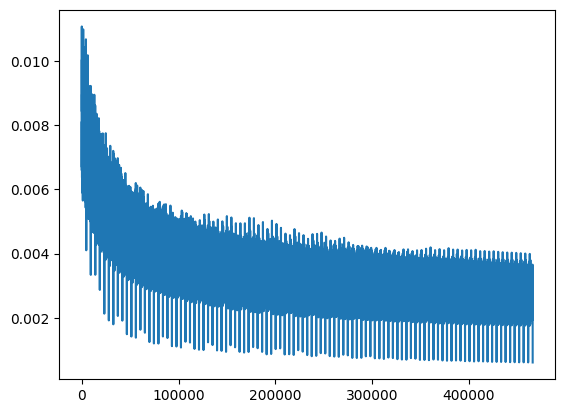

In [16]:
plt.plot(np.arange(len(losses)), losses)